In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


Mounted at /content/drive
/content/drive/MyDrive/dl-project


In [ ]:
!pip install ray[tune]
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 54.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubun

In [ ]:
# copy dataset from google drive to the actual machine
# !rm -rf /content/data/

import os 
DATA_FOLDER = '/content/data/shopee-product-matching/'
if not os.path.isdir(DATA_FOLDER):    
    !mkdir /content/data/
    !cp /content/drive/MyDrive/dl-project/shopee-product-matching.zip /content/data/shopee-product-matching.zip
    !unzip -q /content/data/shopee-product-matching.zip -d /content/data/shopee-product-matching

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from modules.datasets.ImageContrastiveLossShopeeDataset import ImageContrastiveLossShopeeDataset
from modules.losses.ContrastiveLoss import ContrastiveLoss
from modules.models.SiameseNet import SiameseNet
from modules.distances.CosineDistance import CosineDistance
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
import modules.utils.dataset_utils as dataset_utils
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import faiss

In [ ]:
train_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False)
train_df = dataset_utils.add_target(train_df)
train_df.shape

(34250, 6)

In [ ]:
# !rm  ./contrastive_loss_data.csv
CONTRASTIVE_LOSS_DATASET_PATH = './contrastive_loss_data.csv'
train_cl_df = dataset_utils.get_contrastive_loss_dataset(train_df, read_path=CONTRASTIVE_LOSS_DATASET_PATH)
train_cl_df.to_csv(CONTRASTIVE_LOSS_DATASET_PATH, index=False)
train_cl_df.shape

(68500, 7)

In [ ]:
class CFG:
    IMG_SZ = 256
    TRAIN_RATIO = 0.8
    EPOCHS = 10
    MARGIN = 0.5
    DISTANCE = CosineDistance()



In [ ]:
def get_datasets(cl_df):
    unique_ids = np.unique(
        np.concatenate([
            cl_df['posting_id_1'].unique(), 
            cl_df['posting_id_2'].unique()
            ])
        )
    
    # make it deterministic
    np.random.seed(seed=42)
    np.random.shuffle(unique_ids)
    train_size = int(CFG.TRAIN_RATIO * len(unique_ids))
    train_ids = unique_ids[:train_size] 
    valid_ids = unique_ids[train_size:]
    cl_df_train = cl_df[(cl_df['posting_id_1'].isin(train_ids)) | (cl_df['posting_id_2'].isin(train_ids))]
    test_cl_df = cl_df[(~cl_df['posting_id_1'].isin(train_ids)) & (~cl_df['posting_id_2'].isin(train_ids))] 
    
    train_cl_df = cl_df_train.sample(frac=CFG.TRAIN_RATIO, random_state=42)
    valid_cl_df = cl_df_train.drop(train_cl_df.index)

    train_transforms = transforms.Compose([
            transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
            transforms.RandomPosterize(bits=2, p=0.3),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomAutocontrast(p=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    valid_transforms = transforms.Compose([
            transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    train_dataset = ImageContrastiveLossShopeeDataset(
        train_cl_df['image_1'].values,
        train_cl_df['image_2'].values,
        train_cl_df['label'].values,
        train_transforms,
    )

    valid_dataset = ImageContrastiveLossShopeeDataset(
        valid_cl_df['image_1'].values,
        valid_cl_df['image_2'].values,
        valid_cl_df['label'].values,
        valid_transforms,
    )

    test_dataset = ImageContrastiveLossShopeeDataset(
        test_cl_df['image_1'].values,
        test_cl_df['image_2'].values,
        test_cl_df['label'].values,
        valid_transforms,
    )
    
    return train_dataset, valid_dataset, test_dataset

train_cl_df_final = train_cl_df.sample(frac=0.5, random_state=42)
print(train_cl_df_final.shape)
train_dataset, valid_dataset, test_dataset = get_datasets(train_cl_df_final)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

(34250, 7)
26266
6567
1417


In [ ]:
from ray.air import session

def train_model(config, use_tune=True):
    model = ResNet18EmbeddingsShopeeNet(batch_norm=False, freeze_layers=config['freeze'])
    
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, _ = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    siamese_net = SiameseNet(model)
    if torch.cuda.device_count() > 1:
        siamese_net = torch.nn.DataParallel(siamese_net)
    siamese_net.to(device)
    criterion = ContrastiveLoss(device=device, m=CFG.MARGIN, distance=CFG.DISTANCE)
    optimizer = optim.Adam(siamese_net.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config['factor'])

    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           _, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        optimizer.load_state_dict(optimizer_state)
    # Datasets and data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0,
        # persistent_workers=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0,
        # persistent_workers=True,
    )

    train_losses = []
    valid_losses = []
    ## Training loop: training + validation
    for epoch in range(CFG.EPOCHS):
        ## Training
        train_loss = 0.0
        epoch_steps = 0
        model.train()
        siamese_net.train()
        train_enumerator = enumerate(train_loader, 0)
        if not use_tune:
            train_enumerator = tqdm(train_enumerator)
        for i, data in train_enumerator:
            input_1, input_2, target = data
            input_1, input_2, target = input_1.to(device), input_2.to(device), target.to(device)
            optimizer.zero_grad()
            output_1, output_2 = siamese_net(input_1, input_2)
            loss = criterion(output_1, output_2, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1
            if i % 50 == 0:
                print("[%d, %5d / %d batches] loss: %.3f" % (epoch + 1, i + 1, len(train_loader),
                                                train_loss / epoch_steps))
        

        ## Validation
        val_loss = 0.0
        model.eval()
        siamese_net.eval()
        valid_enumerator = enumerate(valid_loader, 0)
        if not use_tune:
            valid_enumerator = tqdm(valid_enumerator)
        for i, data in valid_enumerator:
            with torch.no_grad():
                input_1, input_2, target = data
                input_1, input_2, target = input_1.to(device), input_2.to(device), target.to(device)
                output_1, output_2 = siamese_net(input_1, input_2)
                loss = criterion(output_1, output_2, target)
                val_loss += loss.cpu().numpy()
        if use_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(
                val_loss=(val_loss / len(valid_loader)),
                train_loss=(train_loss / len(train_loader))
                )
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
    if not use_tune:
        return model, train_dataset, valid_dataset, train_losses, valid_losses

In [ ]:
config = {
    "lr": tune.loguniform(1e-6, 1e-1),
    "batch_size": tune.choice([32, 64]),
    "factor": tune.uniform(0.1, 0.99),
    "freeze": tune.choice([3, 6, 7])
}


In [ ]:
def run_hyperparameter_search(num_samples, max_epochs, gpus_per_trial):
    scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=max_epochs,
        grace_period=2,
        reduction_factor=3)
    reporter = CLIReporter(
        metric_columns=["train_loss", "val_loss", "training_iteration"]
        )
    result = tune.run(
        train_model,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        name="train_model_2023-04-23_16-29-56",
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="/root/ray_results",
        resume="LOCAL+ERRORED",
        raise_on_failed_trial=False,)
    return result

In [ ]:
result = run_hyperparameter_search(num_samples=4, max_epochs=CFG.EPOCHS, gpus_per_trial=0.25)

== Status ==
Current time: 2023-04-23 16:29:56 (running for 00:00:00.26)
Memory usage on this node: 3.7/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Resources requested: 2.0/12 CPUs, 0.25/1 GPUs, 0.0/49.86 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-04-23_16-29-56
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------------+----------+----------+-------------+
| Trial name              | status   | loc               |   batch_size |   factor |   freeze |          lr |
|-------------------------+----------+-------------------+--------------+----------+----------+-------------|
| train_model_154a1_00000 | RUNNING  | 172.28.0.12:17952 |           32 | 0.967139 |        3 | 0.00150313  |
| train_model_154a1_00001 | PENDING  |                   |           64 | 0.428183 |        7 | 5.23246e-06 |
| train_model_154a1_0000

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,val_loss,warmup_time
train_model_154a1_00000,2023-04-23_19-00-38,True,,1dddbfe418074a1bb6c661c394edc7fc,4acec4dcdfce,10,172.28.0.12,17952,True,9038.63,931.443,9038.63,1682276438,0,,0.0326664,10,154a1_00000,0.0363948,0.00373745
train_model_154a1_00001,2023-04-23_19-00-31,True,,330cf6e7c0f64273adb4c7029ca28aaf,4acec4dcdfce,10,172.28.0.12,18045,True,9027.68,928.642,9027.68,1682276431,0,,0.0334421,10,154a1_00001,0.0360517,0.00418043
train_model_154a1_00002,2023-04-23_17-00-43,True,,2bd6fe3483794830bea8eb3e4f1b56d3,4acec4dcdfce,2,172.28.0.12,18047,True,1839.28,911.366,1839.28,1682269243,0,,0.0359402,2,154a1_00002,0.0378367,0.00411201
train_model_154a1_00003,2023-04-23_17-01-12,True,,0c140e2abd904716b69ebdc28be5fa7c,4acec4dcdfce,2,172.28.0.12,18049,True,1868.72,926.522,1868.72,1682269272,0,,0.0354233,2,154a1_00003,0.0382963,0.00436831


Streaming output truncated to the last 5000 lines.
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 6.000: -0.03633072546119636 | Iter 2.000: -0.03734192863396071
Resources requested: 4.0/12 CPUs, 0.5/1 GPUs, 0.0/49.86 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-04-23_16-29-56
Number of trials: 4/4 (2 RUNNING, 2 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+----------+-------------+--------------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   factor |   freeze |          lr |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+----------+-------------+--------------+------------+----------------------|
| train_model_154a1_00000 | RUNNING    | 172.28.0.12:17952 |           32 | 0.967139 |        3 | 0.00150313  |   

2023-04-23 19:00:38,614	INFO tune.py:798 -- Total run time: 9042.31 seconds (9042.22 seconds for the tuning loop).


== Status ==
Current time: 2023-04-23 19:00:38 (running for 02:30:42.23)
Memory usage on this node: 7.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 6.000: -0.03633072546119636 | Iter 2.000: -0.03734192863396071
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.86 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-04-23_16-29-56
Number of trials: 4/4 (4 TERMINATED)
+-------------------------+------------+-------------------+--------------+----------+----------+-------------+--------------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   factor |   freeze |          lr |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+-------------------+--------------+----------+----------+-------------+--------------+------------+----------------------|
| train_model_154a1_00000 | TERMINATED | 172.28.0.12:17952 |      

In [ ]:
# Keep it on google drive for the future 
!mkdir ./analysis/
!mkdir ./analysis/cl-images/
!cp -r /root/ray_results/train_model_2023-04-23_16-29-56 ./analysis/cl-images/

In [ ]:
# best_trial = 'train_model_66040_00006'
# print(best_trial)
best_trial = result.get_best_trial("val_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final training loss: {}".format(best_trial.last_result["train_loss"]))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))

my_trials = [ trial for trial in list(result.trial_dataframes.keys()) if str(best_trial) in trial]
print(my_trials)
best_checkpoint = result.get_best_checkpoint(trial=my_trials[0], metric="val_loss", mode="min")
train_losses = result.trial_dataframes[my_trials[0]]["train_loss"].values
val_losses = result.trial_dataframes[my_trials[0]]["val_loss"].values
print(f"Train losses: {val_losses}")
print(f"Validation losses: {val_losses}")

Best trial config: {'lr': 5.232464374426386e-06, 'batch_size': 64, 'factor': 0.42818285804182743, 'freeze': 7}
Best trial final training loss: 0.033442105327499465
Best trial final validation loss: 0.03605168735952053
['/root/ray_results/train_model_2023-04-23_16-29-56/train_model_154a1_00001_1_batch_size=64,factor=0.4282,freeze=7,lr=0.0000_2023-04-23_16-29-59']
Train losses: [0.03769534 0.03713161 0.03694309 0.03662386 0.03650322 0.03634797
 0.03622517 0.03618117 0.0360881  0.03605169]
Validation losses: [0.03769534 0.03713161 0.03694309 0.03662386 0.03650322 0.03634797
 0.03622517 0.03618117 0.0360881  0.03605169]


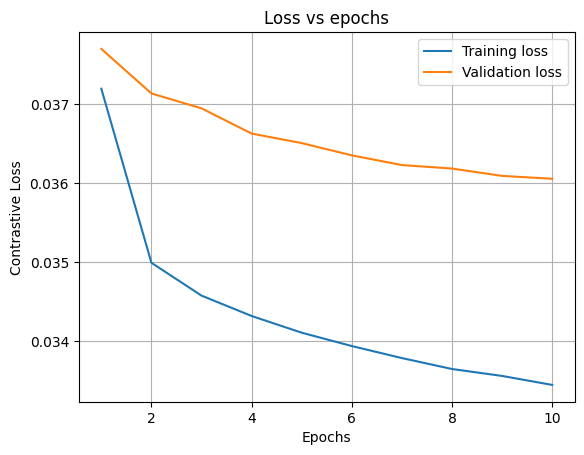

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, 11), train_losses, label='Training loss')
plt.plot(np.arange(1, 11), val_losses, label='Validation loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.title('Loss vs epochs')
plt.legend(loc='best')
plt.grid(True)

plt.savefig('cnn-contrastive-loss-cosine-losses-2.png')

In [ ]:
best_model = ResNet18EmbeddingsShopeeNet(freeze_layers=best_trial.config['freeze'])
best_checkpoint_dir = best_checkpoint.to_directory(path="directory")
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
best_model.load_state_dict(model_state)
torch.save(best_model.state_dict(), f"./best_model_params_cosine_x1.pt")

In [ ]:
best_model.load_state_dict(torch.load("./best_model_params_cosine_x1.pt"))

<All keys matched successfully>

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(DEVICE)

from modules.datasets.ImageShopeeDataset import ImageShopeeDataset

images_dataset = ImageShopeeDataset(
    train_df['image'].values,
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

images_loader = torch.utils.data.DataLoader(
    images_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

image_embeddings = []
i = 0
with torch.no_grad():
    for data in tqdm(images_loader):
        i += 1
        data = data.to(DEVICE)
        embeddings = best_model(data)
        embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[1])
        embeddings = embeddings.detach().cpu().numpy()
        image_embeddings.extend(embeddings)

100%|██████████| 536/536 [07:57<00:00,  1.12it/s]


In [ ]:
image_embeddings = np.stack(image_embeddings)
norms = np.linalg.norm(image_embeddings, axis=1)
image_embeddings = image_embeddings / norms[:, np.newaxis]
image_embeddings.shape

(34250, 512)

In [ ]:
k = 100
res = faiss.StandardGpuResources()
index_img = faiss.IndexFlatIP(512)
# index_img = faiss.index_cpu_to_gpu(res, 0, index_img)
index_img.add(image_embeddings)
similarities_img, indexes_img = index_img.search(image_embeddings, k)

In [ ]:
def calc_f1_score(targets, results):
    intersect = len(np.intersect1d(targets, results))
    return 2 * intersect / (len(targets) + len(results))


def process_for_threshold(similarities, indexes, threshold):
    f1_score_accumulated = 0
    for i in range(len(image_embeddings)):
        cur_sims = similarities[i]
        cur_indexes = indexes[i]
        duplicate_indexes = cur_indexes[cur_sims >= threshold]
        results = train_df.iloc[duplicate_indexes]['posting_id'].values
        targets = train_df.iloc[i]['target']
        f1_score = calc_f1_score(targets, results)
        f1_score_accumulated += f1_score
    return f1_score_accumulated / len(image_embeddings)


thresholds = np.arange(0.83, 0.97, 0.01)
f1_avg_scores = []
for threshold in tqdm(thresholds):
    f1_avg = process_for_threshold(similarities_img, indexes_img, threshold)
    f1_avg_scores.append(f1_avg)

100%|██████████| 15/15 [02:49<00:00, 11.33s/it]


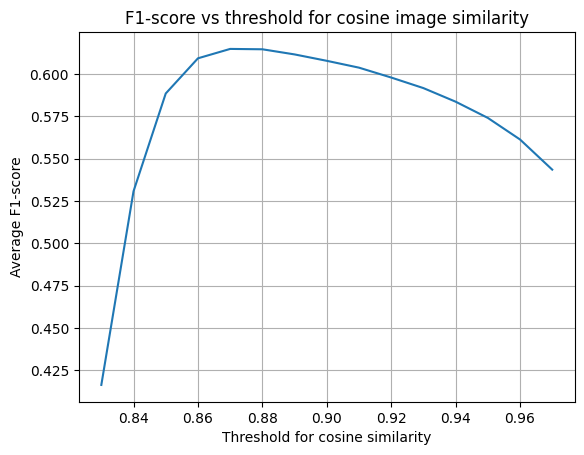

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_avg_scores)

# Add labels and title
plt.xlabel('Threshold for cosine similarity')
plt.ylabel('Average F1-score')
plt.title('F1-score vs threshold for cosine image similarity')
plt.grid(True)

max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]

# Save the plot to a file
plt.savefig('cnn-contrastive-loss-cosine-thresholds-all.png')

In [ ]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 

Max f1-score: 0.6148752793604176, threshold: 0.87


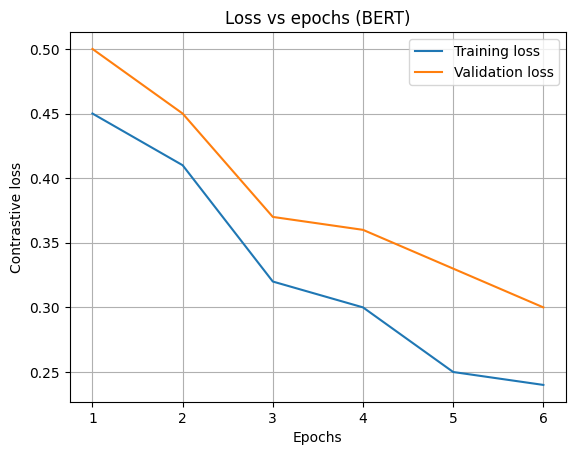

In [2]:
from modules.utils.CommonVIsualizer import CommonVisualizer
visualizer = CommonVisualizer()
train_losses = [0.45, 0.41, 0.32, 0.30, 0.25, 0.24]
val_losses = [0.5, 0.45, 0.37, 0.36, 0.33, 0.30]
visualizer.plt_losses(train_losses, val_losses, 'BERT', 'Contrastive loss', 'example.png')